In [1]:
import nectarUtils
from nectarUtils import *
import nectarUtils as nu

import importlib


%matplotlib inline
print(sys.version)
print(sys.executable)

# define directories
baseDir = os.getcwd()

# may want to make this directory somewhere else, if dropbox becomes a problem
dataDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarData"
if not os.path.isdir(dataDir):
    os.mkdir(dataDir)

figDir = r"D:\Dropbox\AcademiaDropbox\UW\BeeDecisionProject\NectarFigs"
if not os.path.isdir(figDir):
    os.mkdir(figDir)

3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
C:\Users\Combes4\Anaconda2\envs\NectarLearning\python.exe


In [2]:
# list serial ports
nu.serial_ports()

['COM4', 'COM8']

In [3]:
# connect to com8
PORT1 = "COM4"
connected1 = False
if "ser1" in globals():
    ser1.close()
ser1 = serial.Serial(PORT1,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected1:
    serin1 = ser1.read()
    connected1 = True
    print("connected to arduino on " + PORT1)
str(ser1.readline().decode("UTF-8"))    

connected to arduino on COM4


' Setup complete\r\n'

In [4]:
# connect to com8
PORT2 = "COM8"
connected2 = False
if "ser2" in globals():
    ser2.close()
ser2 = serial.Serial(PORT2,9600, timeout=1.0) # stop if no data comes in 1 second
while not connected2:
    serin2 = ser2.read()
    connected2 = True
    print("connected to arduino on " + PORT2)
str(ser2.readline().decode("UTF-8"))    

connected to arduino on COM8


' Setup complete\r\n'

In [5]:
# reload package if changed
_ = importlib.reload(nectarUtils)
from multiprocessing import cpu_count, Process, Pool

In [6]:
def moveBack(ser):
    ser.write("ff".encode("utf-8"))
    raise("ERROR")
    return("Hihi" + ser.port)

In [8]:
moveBack(ser1)

TypeError: exceptions must derive from BaseException

In [349]:
ser2.write("ff".encode("utf-8"))

2

In [10]:
# try multiple threads
import threading

In [ ]:
# thread = threading.Thread(target=nu.calibrate, args=(ser1,))
# thread2 = threading.Thread(target=nu.calibrate, args=(ser2,))
# thread.start()
# thread2.start()

# return_value = thread.join()
# rv2 = thread2.join()

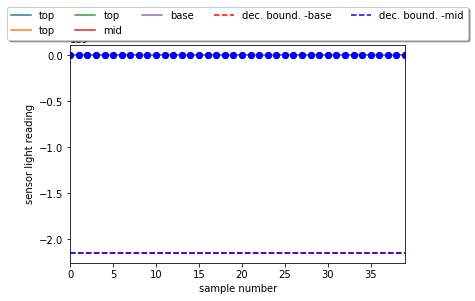

C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
Exception in thread Thread-13:
Traceback (most recent call last):
  File "C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\Combes4\Documents\GitRepos\NectarLearning\PythonCode\nectarUtils.py", l

In [15]:
thread = threading.Thread(target = nu.calibrate, args=(ser1,), daemon = True)
thread2 = threading.Thread(target=nu.calibrate, args=(ser2,), daemon = True)
thread.start()
thread2.start()

# return_value = thread.join()
# rv2 = thread2.join()

C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\site-packages\sklearn\cluster\k_means_.py:971: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Combes4\Anaconda2\envs\NectarLearning\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\

Empty: 

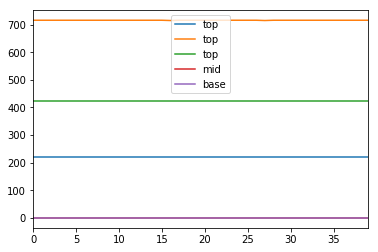

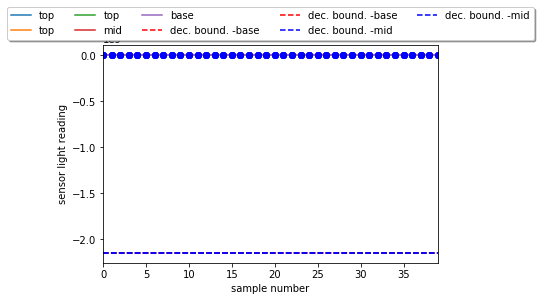

In [359]:
import queue
def enthread(target, args):
    q = queue.Queue()
    def wrapper():
        q.put(target(*args))
    t = threading.Thread(target=wrapper)
    t.start()
    return(q)

q1 = enthread(target = nu.calibrate, args=(ser1,))
q2 = enthread(target = nu.calibrate, args=(ser2,))

# refref: return NA if there is a timeout
rr = q1.get(timeout=10)
r2 = q2.get(timeout=10)

In [358]:
rr, r2

({'topBaseline': 424.65,
  'midBaseline': 181.75,
  'baseBaseline': 117.0,
  'colNames': array(['base', 'mid', 'top', 'limit', 'limit'], dtype=object),
  'port': 'COM4',
  'base_dec_bound': 170,
  'mid_dec_bound': 449},
 {'topBaseline': 155.15,
  'midBaseline': 187.25,
  'baseBaseline': 161.0,
  'colNames': array(['mid', 'top', 'base', 'limit', 'limit'], dtype=object),
  'port': 'COM8',
  'base_dec_bound': 323,
  'mid_dec_bound': 403})

In [ ]:
moveBack(ser2)

In [ ]:
stt = time.time()
p = Pool(2)
stt = time.time()   
bb = p.map(moveBack, [ser1, ser2] ) 
print(time.time() - stt)

p.close()
p.join()



In [ ]:
bb

In [ ]:
_ = importlib.reload(TwoProcesses)
TwoProcesses.f1(150)

In [ ]:
# max number of processes
cpu_count()

In [ ]:
stt = time.time()
p = Pool(2)
stt = time.time()   
bb = p.map(TwoProcesses.f1, [100,150, 100, 100, 100] ) 
print(time.time() -stt)

p.close()
p.join()

In [ ]:
bb